In [18]:
import pandas as pd
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from textblob import TextBlob
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize

In [19]:
test_data = pd.read_csv(r'C:\Users\markham\OneDrive\Desktop\processed_articles_2019_V3.csv')
test_data['content'] = test_data['title'] + test_data['body']
test_data = test_data.drop(columns=['title','body'])
test_data['date'] = pd.to_datetime(test_data['date'])
test_data = test_data.sort_values(by='date')
test_data

,date,content
654,2018-12-31,"['mattis', 'exit', 'tell', 'u', 'military', 'k..."
572,2018-12-31,"['u', 'democrats', 'manoeuvre', 'end', 'shutdo..."
545,2018-12-31,"['frenchman', 'nasri', 'complete', 'west', 'ha..."
5,2018-12-31,"['russian', 'apartment', 'block', 'blast', 'ki..."
610,2018-12-31,"['wall', 'street', 'rise', 'limp', 'finish', '..."
...,...,...
1838,2019-01-31,"['south', 'korea', 'kdb', 'sign', 'deal', 'hyu..."
1839,2019-01-31,"['fifth', 'asian', 'cup', 'title', 'would', 'm..."
1840,2019-01-31,"['mediacoal', 'india', 'talk', 'gail', 'ioc', ..."
1834,2019-01-31,"['modi', 'see', 'appease', 'voter', 'put', 're..."


In [20]:
# 训练 Word2Vec 模型
model = Word2Vec(sentences=test_data['content'], vector_size=50, window=5, min_count=1, workers=4)

# 定义一个函数，将文本转换为向量
def text_to_vector(text, model):
    vectors = []
    for word in text:
        if word in model.wv:
            vectors.append(model.wv[word])
    if not vectors:
        # 如果文本中没有有效的词向量，返回全零向量
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

# 将每条新闻转换为向量
test_data['vector'] = test_data['content'].apply(lambda x: text_to_vector(x, model))

In [21]:
# 提取所有新闻的向量数据
X = np.array(test_data['vector'].tolist())

# 假设聚类数量为 2，可根据实际情况调整
num_clusters = 3

# 创建 KMeans 模型
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# 进行聚类
labels = kmeans.fit_predict(X)

# 将聚类标签添加到原数据中
test_data['cluster_label'] = labels
test_data


,date,content,vector,cluster_label
654,2018-12-31,"['mattis', 'exit', 'tell', 'u', 'military', 'k...","[0.08448834, 0.24551262, -0.16842397, 0.334090...",2
572,2018-12-31,"['u', 'democrats', 'manoeuvre', 'end', 'shutdo...","[0.085713945, 0.24692275, -0.16409147, 0.33030...",2
545,2018-12-31,"['frenchman', 'nasri', 'complete', 'west', 'ha...","[0.08707151, 0.24669956, -0.16839384, 0.333347...",0
5,2018-12-31,"['russian', 'apartment', 'block', 'blast', 'ki...","[0.081460565, 0.24910446, -0.15993561, 0.32467...",0
610,2018-12-31,"['wall', 'street', 'rise', 'limp', 'finish', '...","[0.075275674, 0.25463676, -0.1782166, 0.328272...",2
...,...,...,...,...
1838,2019-01-31,"['south', 'korea', 'kdb', 'sign', 'deal', 'hyu...","[0.064438984, 0.25450584, -0.14728698, 0.31519...",0
1839,2019-01-31,"['fifth', 'asian', 'cup', 'title', 'would', 'm...","[0.0677327, 0.26804683, -0.15742205, 0.3325975...",0
1840,2019-01-31,"['mediacoal', 'india', 'talk', 'gail', 'ioc', ...","[0.116232015, 0.20716174, -0.12688182, 0.29140...",1
1834,2019-01-31,"['modi', 'see', 'appease', 'voter', 'put', 're...","[0.09154979, 0.24604875, -0.17591508, 0.336471...",2


In [22]:
# 评估聚类效果
if len(set(labels)) > 1:
    silhouette = silhouette_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)
    print(f"轮廓系数: {silhouette}")
    print(f"Calinski - Harabasz 指数: {ch_score}")
else:
    print("由于簇的数量不大于 1，无法计算聚类评估指标。")


轮廓系数: 0.11792886257171631
Calinski - Harabasz 指数: 305.5147436398075


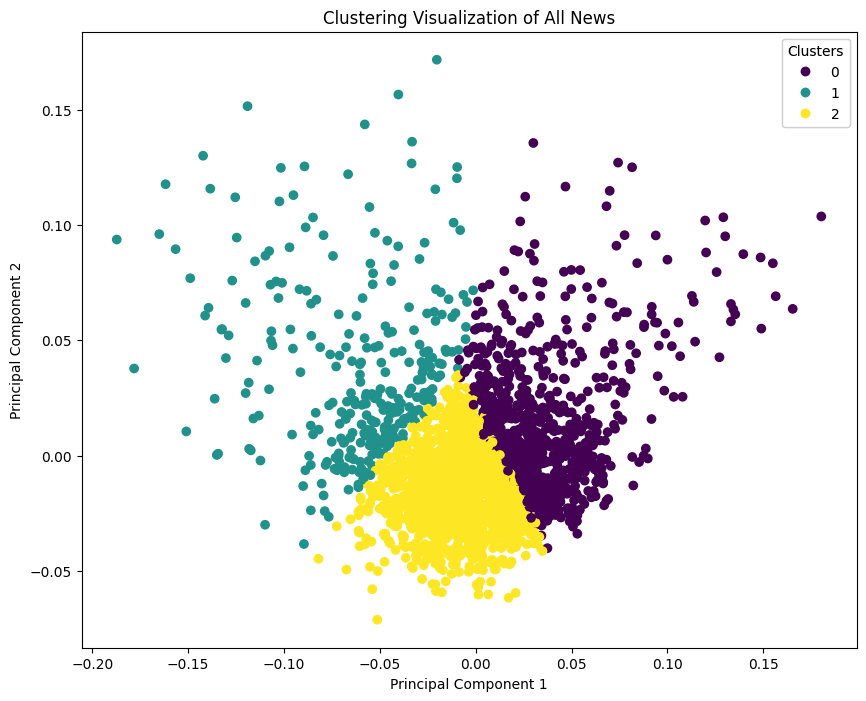

In [23]:
# 使用 PCA 将数据降到二维
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# 绘制散点图
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
legend = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend)
plt.title('Clustering Visualization of All News')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [26]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 将日期转换为日期类型
test_data['date'] = pd.to_datetime(test_data['date'])
# 按日期分组
grouped = test_data.groupby('date')

# 加载 DistilBERT 模型和分词器
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

# 存储每天每个聚类的情感指数结果
sentiment_results = []

# 将模型移到 GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for date, group in grouped:
    for cluster in range(num_clusters):
        cluster_data = group[group['cluster_label'] == cluster]
        sentiment_scores = []
        
        for content in cluster_data['content']:
            # 如果 content 是列表，将其转换为字符串
            if isinstance(content, list):
                text = " ".join(str(item) for item in content)
            else:
                text = str(content)
                
            try:
                # 编码文本，设置最大长度为 512
                inputs = tokenizer(text, return_tensors="pt", truncation=True, 
                                 padding=True, max_length=512)
                # 将输入移到相同的设备
                inputs = {k: v.to(device) for k, v in inputs.items()}
                
                # 获取模型输出
                with torch.no_grad():
                    outputs = model(**inputs)
                
                # 处理预测结果
                logits = outputs.logits
                probabilities = torch.nn.functional.softmax(logits, dim=-1)
                
                # DistilBERT SST-2 的标签顺序：negative [0], positive [1]
                positive_prob = probabilities[0][1].item()
                negative_prob = probabilities[0][0].item()
                
                # 计算情感得分：积极概率 - 消极概率
                sentiment_score = positive_prob - negative_prob
                sentiment_scores.append(sentiment_score)
                
            except Exception as e:
                print(f"处理文本时出错: {text[:50]}...，错误信息: {e}")
                continue
        
        # 计算平均情感得分
        average_sentiment = sum(sentiment_scores) / len(sentiment_scores) if sentiment_scores else 0
        
        sentiment_results.append({
            'date': date,
            'cluster': cluster,
            'sentiment_score': average_sentiment,
            'num_samples': len(sentiment_scores)  # 添加样本数，便于检查
        })

# 创建 DataFrame
sentiment_df = pd.DataFrame(sentiment_results)

# 打印结果
print(sentiment_df)

         date  cluster  sentiment_score  num_samples
0  2018-12-31        0        -0.977577            2
1  2018-12-31        1         0.000000            0
2  2018-12-31        2        -0.980915            6
3  2019-01-01        0        -0.727647           41
4  2019-01-01        1        -0.715246           12
..        ...      ...              ...          ...
91 2019-01-30        1        -0.538802           16
92 2019-01-30        2        -0.836260           44
93 2019-01-31        0        -0.856275           23
94 2019-01-31        1        -0.905058            7
95 2019-01-31        2        -0.915992           36

[96 rows x 4 columns]
